##      **Chest X-ray - Tuberculosis Disease Prediction**

# Downloading the Dataset
First, we need to install the Kaggle API and authenticate it to download the "Chest X-ray - Tuberculosis Disease Image" dataset.

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
!unzip tuberculosis-tb-chest-xray-dataset.zip -d tuberculosis-tb-chest-xray-dataset1

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 99% 657M/663M [00:04<00:00, 182MB/s]
100% 663M/663M [00:04<00:00, 168MB/s]
Archive:  tuberculosis-tb-chest-xray-dataset.zip
  inflating: tuberculosis-tb-chest-xray-dataset1/TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: tuberculosis-tb-chest-xray-dataset1/TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: tuberculosis-tb-chest-xray-dataset1/TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: tuberculosis-tb-chest-xray-dataset1/TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: tuberculosis-tb-chest-xray-dataset1/TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: tuberculosis-tb-chest-xray-dataset1/TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: tuberculosis-tb-chest-xray-dataset1/TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: tuberculosis-tb-c

# Creating CSV files for train and test dataset :-

we are pre-processing the data and creating train_data.csv  and test_data.csv file with columns image_path and label for further processing:-


In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Directories for the dataset
dataset_dir1 = '/content/tuberculosis-tb-chest-xray-dataset1/TB_Chest_Radiography_Database'

# Initialize lists to hold image paths and labels
image_paths = []
labels = []

# Function to process the directory
def process_directory(directory, label_list, path_list):
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.endswith('.jpg') or image_name.endswith('.png'):
                    image_path = os.path.join(label_dir, image_name)
                    path_list.append(image_path)
                    label_list.append(label)

# Process the dataset directory
process_directory(dataset_dir1, labels, image_paths)

# Create DataFrame
data = {'Image_Path': image_paths, 'Label': labels}
df = pd.DataFrame(data)

# Calculate the subset size which is 10.00% of the total data
subset_size = int(0.1000 * len(df))

# Split the data to get 10.00% of the entire dataset
_, subset_df = train_test_split(df, train_size=subset_size, stratify=df['Label'], random_state=42)

# Further split the subset into train and validation sets
train_df, test_df = train_test_split(subset_df, test_size=0.1, stratify=subset_df['Label'], random_state=42)
test_df['Label'] = "Unknown"

# Save to CSV
train_csv_path = '/content/tuberculosis-tb-chest-xray-dataset1/train_data.csv'
test_csv_path = '/content/tuberculosis-tb-chest-xray-dataset1/test_data.csv'

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print("CSV files for train and validation data saved successfully!")

CSV files for train and validation data saved successfully!


# Importing Libraries :-

we need to import machine learning related API's for image processing , manipulating layers and model Xception , InceptionV3 and ResNet50V2 with pre-trained weights , pandas for reading csv files into dataframes and Matplotlib for creating visualizations, such as line plots, bar charts :-

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception, DenseNet121, MobileNetV2, ResNet50V2, InceptionV3
from keras import layers, models, optimizers

from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.models import Sequential

# Creating Data Generators for Image Classification
This code snippet summarizes the process of creating data generators for training and validation sets . It includes setting up image data augmentation for the training set (train_datagen) and scaling for the testing set (test_datagen), defining the batch size and target image size, and loading the dataset using the flow_from_directory method with categorical class mode for image classification tasks.

In [5]:
# Load the dataset
df = pd.read_csv('/content/tuberculosis-tb-chest-xray-dataset1/train_data.csv')

# Ensure we have 17 unique classes
num_classes = len(df['Label'].unique())
print(num_classes)

# Define the stratified shuffle split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

# Perform the split
for train_index, val_index in split.split(df, df['Label']):
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
target_size = (224, 224)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='Image_Path',
                                                    y_col='Label',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                        x_col='Image_Path',
                                                        y_col='Label',
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

2
Found 3061 validated image filenames belonging to 2 classes.
Found 341 validated image filenames belonging to 2 classes.


# Exploratory Data Analysis

In [6]:
# Understand the dataset
print(train_df.head())
print(train_df.shape)
print(train_df.info())
print(train_df.describe())

                                             Image_Path         Label
1986  /content/tuberculosis-tb-chest-xray-dataset1/T...  Tuberculosis
257   /content/tuberculosis-tb-chest-xray-dataset1/T...  Tuberculosis
1708  /content/tuberculosis-tb-chest-xray-dataset1/T...        Normal
3368  /content/tuberculosis-tb-chest-xray-dataset1/T...        Normal
646   /content/tuberculosis-tb-chest-xray-dataset1/T...        Normal
(3061, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 3061 entries, 1986 to 1008
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Path  3061 non-null   object
 1   Label       3061 non-null   object
dtypes: object(2)
memory usage: 71.7+ KB
None
                                               Image_Path   Label
count                                                3061    3061
unique                                               3061       2
top     /content/tuberculosis-tb-chest-xray-dataset1/T...  Nor

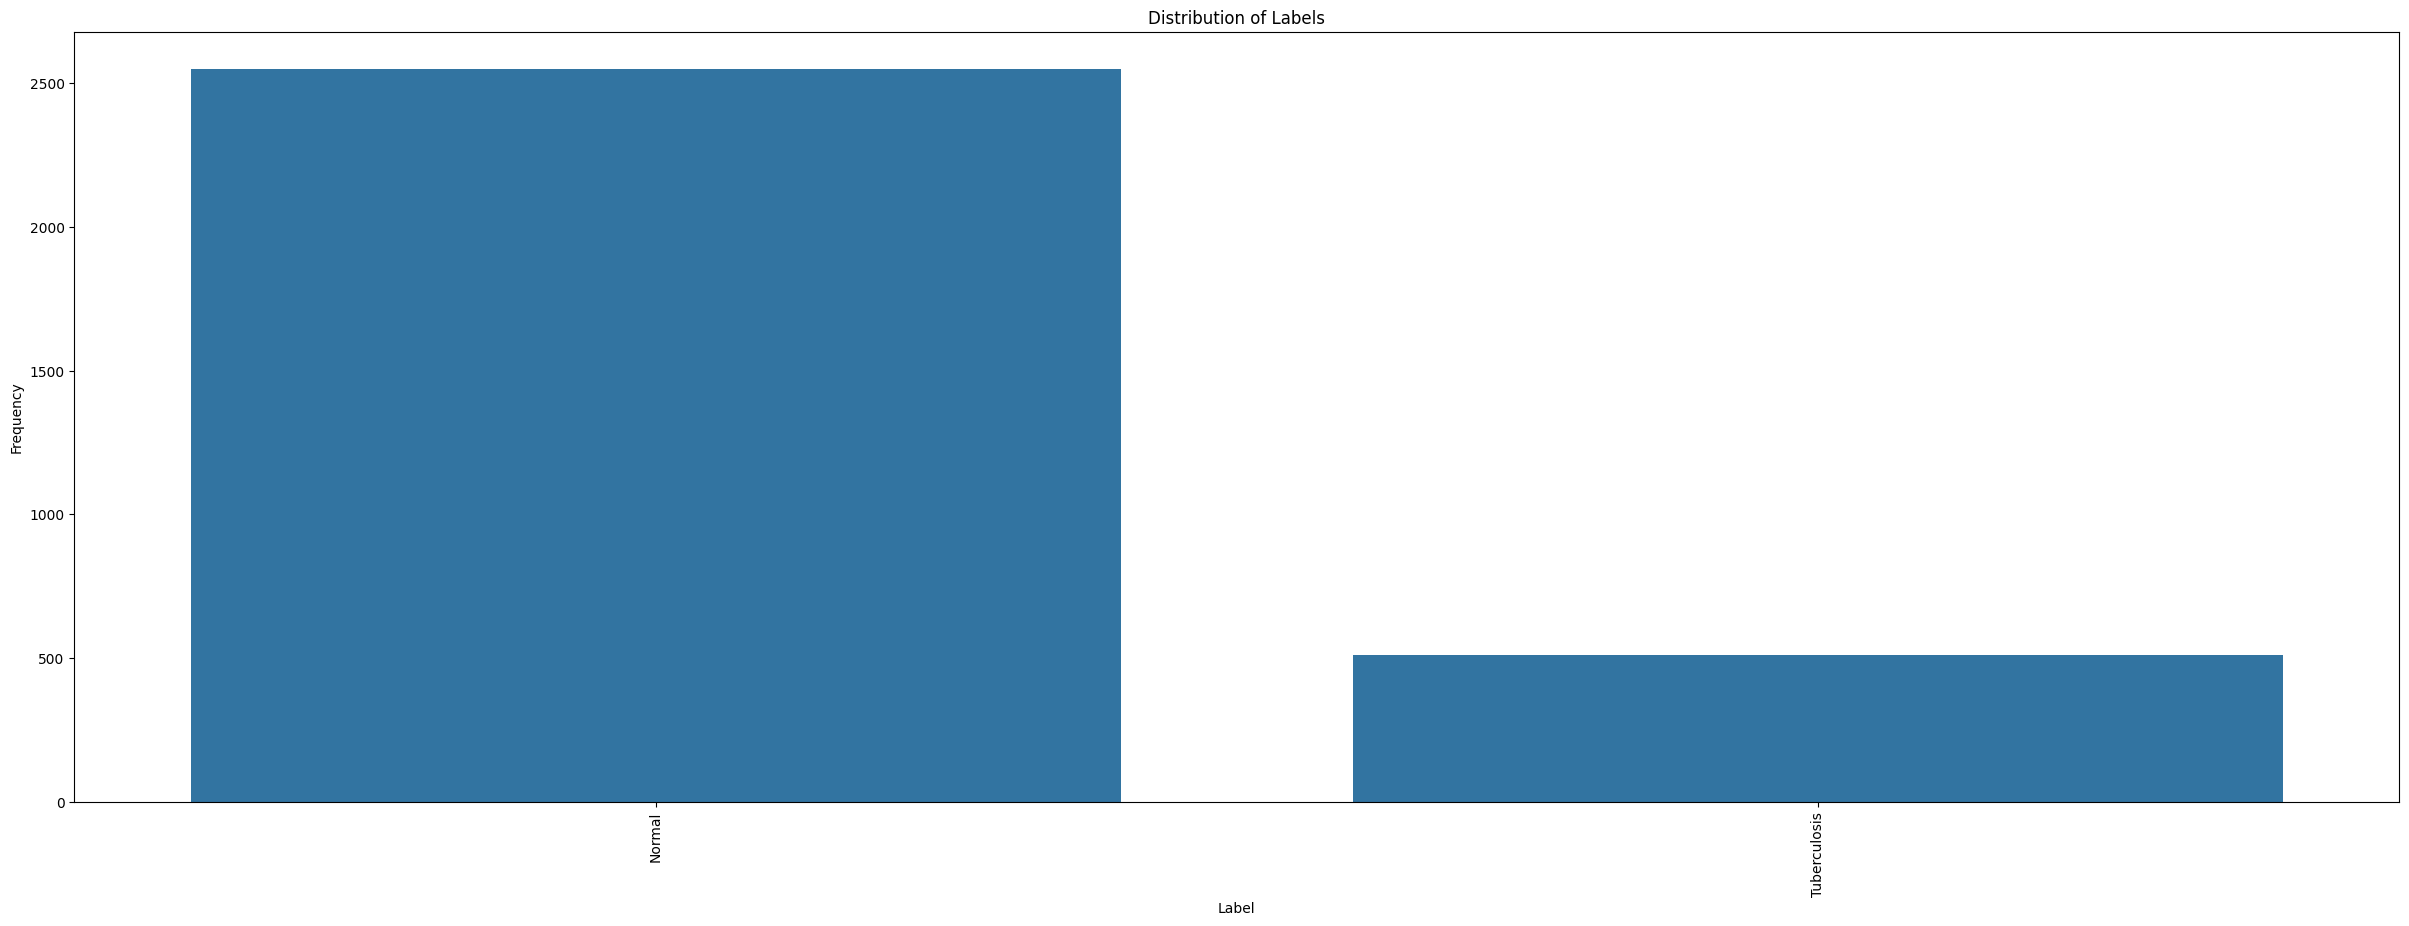

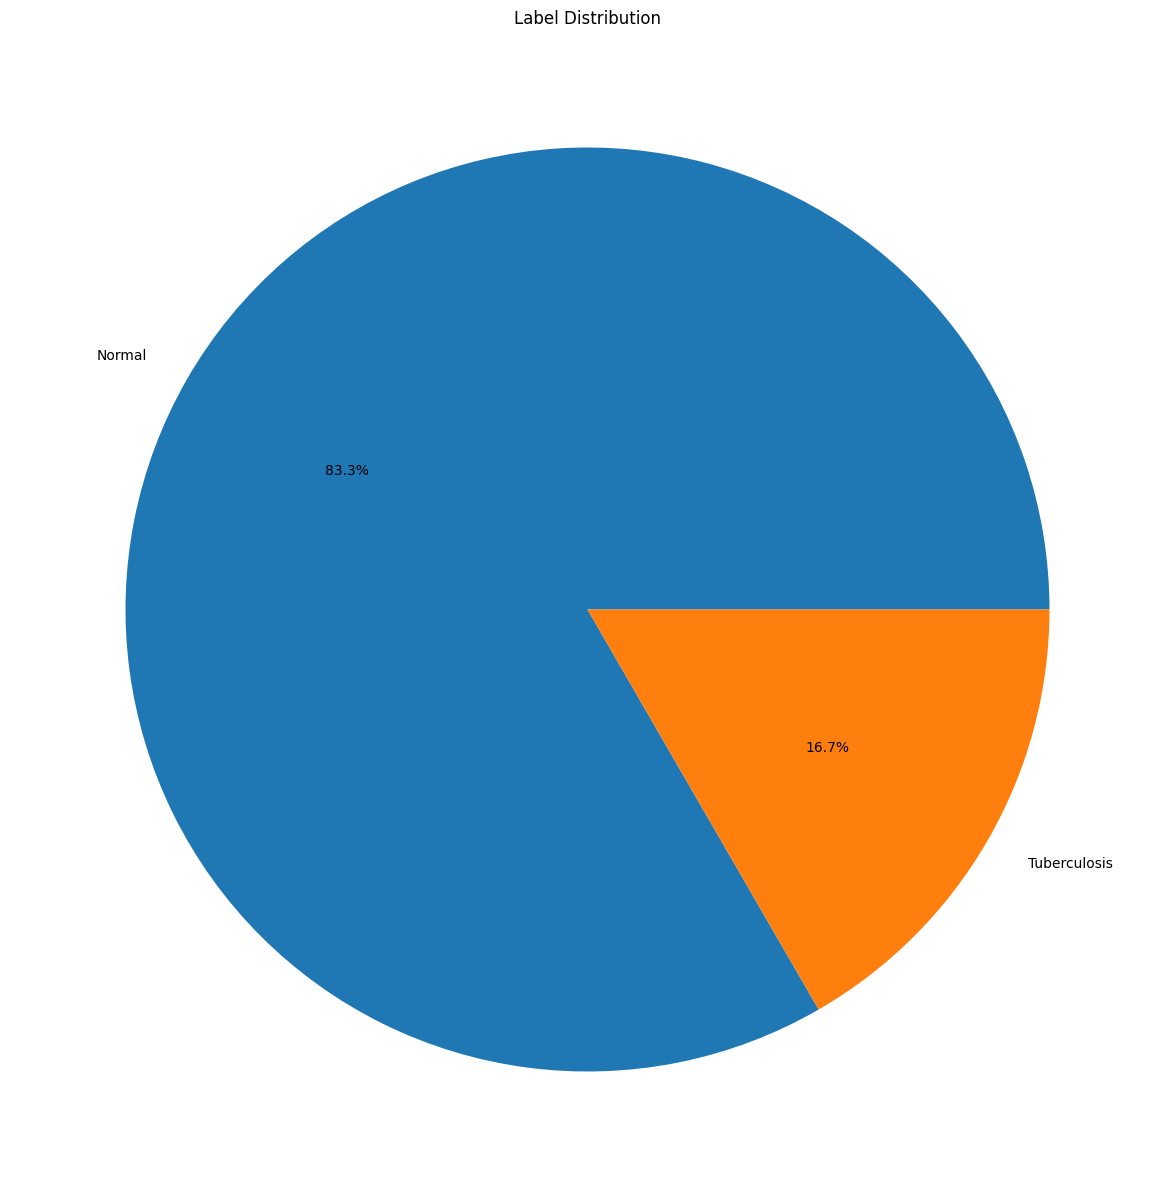

In [ ]:
# Bar chart for label distribution
plt.figure(figsize=(30, 10))
sns.countplot(data=train_df, x='Label', order=train_df['Label'].value_counts().index)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.show()

# Pie chart for label distribution
plt.figure(figsize=(15, 15))
train_df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Label Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()

Number of unique image paths: 3061


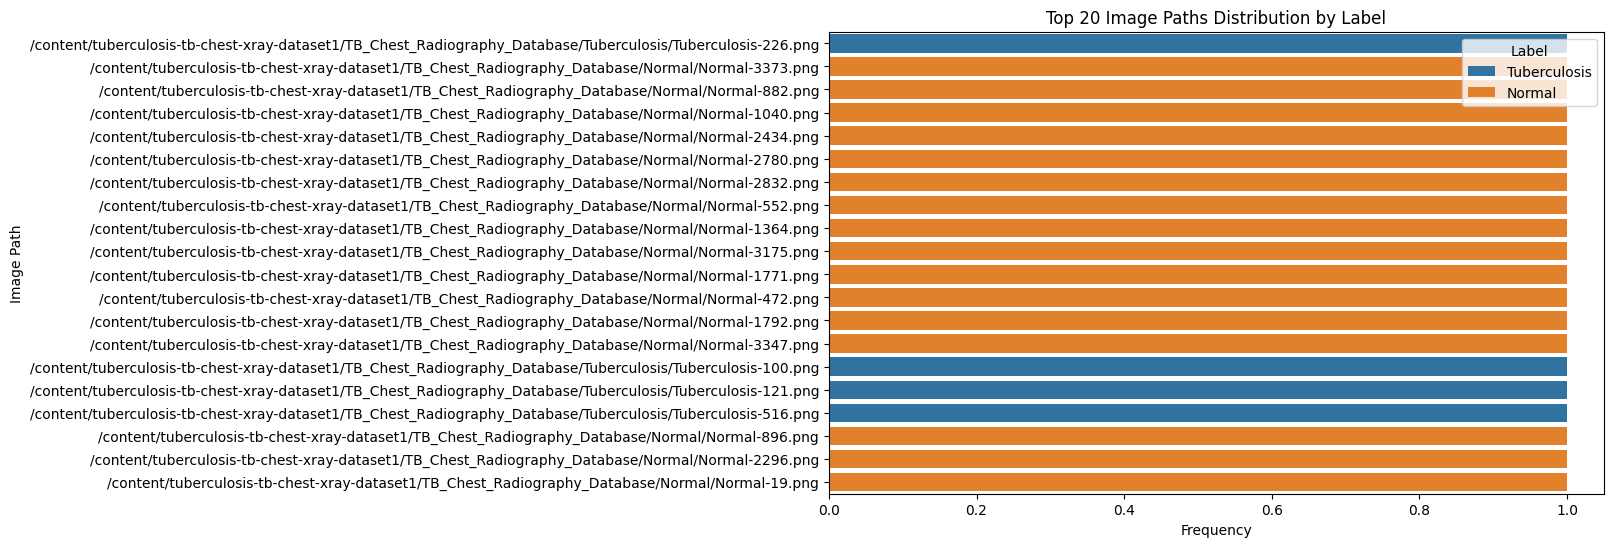

Column Image_Path has 3061 unique values.
Column Label has 2 unique values.


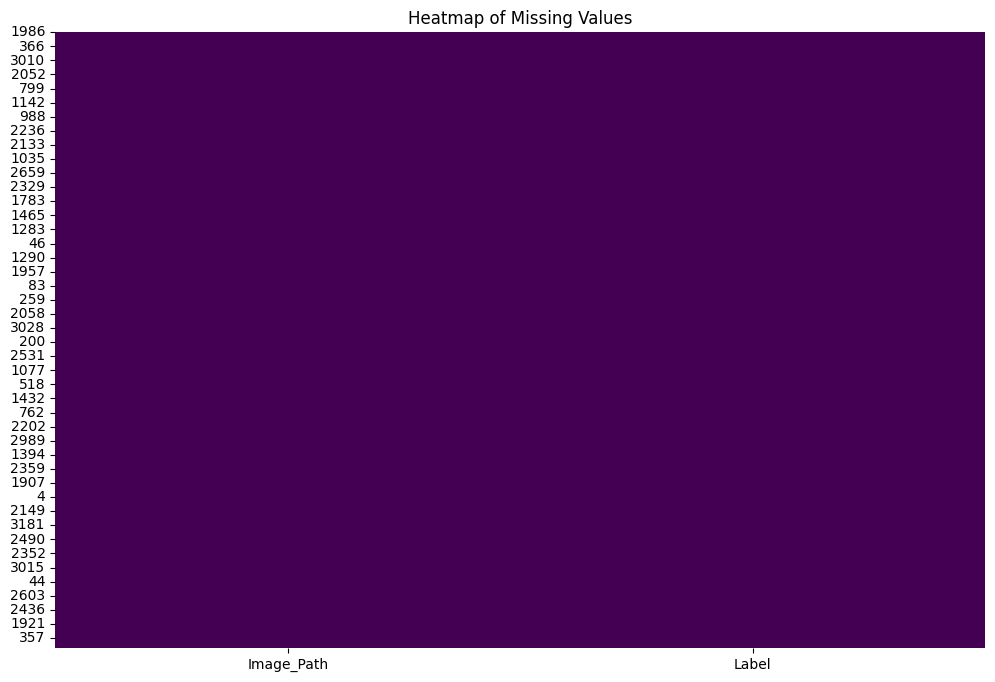

Label
Normal          2551
Tuberculosis     510
Name: count, dtype: int64


In [ ]:
# Count unique image paths
unique_paths = train_df['Image_Path'].nunique()
print(f"Number of unique image paths: {unique_paths}")

# Image paths distribution by label (top 20 paths for readability)
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, y='Image_Path', hue='Label', order=train_df['Image_Path'].value_counts().index[:20])
plt.title('Top 20 Image Paths Distribution by Label')
plt.xlabel('Frequency')
plt.ylabel('Image Path')
plt.show()

# Unique values for each categorical column
for column in train_df.select_dtypes(include=['object']).columns:
    unique_values = train_df[column].nunique()
    print(f"Column {column} has {unique_values} unique values.")

# Missing values heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

# Label counts summary
label_counts = train_df['Label'].value_counts()
print(label_counts)

In [ ]:
# Data Cleaning
print(train_df.isnull().sum())
train_df.fillna(method='ffill', inplace=True)
print(train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)

Image_Path    0
Label         0
dtype: int64
0


<ipython-input-10-f446af628159>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.fillna(method='ffill', inplace=True)
<ipython-input-10-f446af628159>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop_duplicates(inplace=True)


# Customizing model according to our usecase
This code snippet summarizes the process of creating a custom keras categorical classification model in Keras. It involves loading the pre-trained Xception , VGG16 and ResNet50  model, freezing its layers, adding custom layers for classification, compiling the model, shuffling the training data, and training the model. Finally, the trained model is saved as an HDF5 file .

In [7]:
from keras.layers import Dense
def create_model(base_model, num_classes):
    base_model.trainable = False  # Freeze the base model initially
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def train_and_evaluate(model, train_data, val_data, model_name, epochs=10):
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    checkpoint = ModelCheckpoint(filepath=f'{model_name}_best_model.h5', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model.fit(train_data,
                        validation_data=val_data,
                        steps_per_epoch=len(train_data),
                        epochs=epochs,
                        callbacks=[early_stopping, reduce_lr, checkpoint])

    # Load the best model
    model.load_weights(f'{model_name}_best_model.h5')

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_data)
    print(f'{model_name} Validation Accuracy: {val_accuracy:.4f}')

    # Plot training history
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Accuracy')
    plt.show()

    # Confusion Matrix
    val_data.reset()
    Y_pred = model.predict(val_data)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = val_data.classes

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return history

In [9]:
def model_training(base_models):
    # Directory to save the models
    save_dir = 'saved_models'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Train and evaluate each model
    histories = {}
    for base_model, input_shape, model_name in base_models:
        model = create_model(base_model, num_classes)

        print(f'Training {model_name}...')
        history = train_and_evaluate(model, train_generator, validation_generator, model_name, epochs=10)
        histories[model_name] = history

        # Save the model
        model.save(os.path.join(save_dir, f'{model_name}_saved.h5'))
        print(f'Saved {model_name} model to {save_dir}/{model_name}_saved.h5')

# Loading the Base-Model
This code snippet defines Xception , ResNet50 and VGG16 base model in Keras. The model is configured with an input shape of (224, 224, 3) for VGG16 & ResNet50 and input shape of (299 , 299 , 3) for Xception to match the size and channels of the images in the dataset. It includes all layers of the MobileNetV2 model up to the final fully connected layers but excludes the last fully connected layer, which is often customized for specific tasks.

Training MobileNetV2...
Epoch 1/10
96/96 [==============================] - 67s 661ms/step - loss: 0.4434 - accuracy: 0.8367 - val_loss: 0.2528 - val_accuracy: 0.8944 - lr: 1.0000e-04
Epoch 2/10
96/96 [==============================] - 65s 680ms/step - loss: 0.1570 - accuracy: 0.9383 - val_loss: 0.2173 - val_accuracy: 0.9120 - lr: 1.0000e-04
Epoch 3/10
96/96 [==============================] - 61s 637ms/step - loss: 0.1138 - accuracy: 0.9572 - val_loss: 0.2084 - val_accuracy: 0.9238 - lr: 1.0000e-04
Epoch 4/10
96/96 [==============================] - 62s 648ms/step - loss: 0.1020 - accuracy: 0.9611 - val_loss: 0.2295 - val_accuracy: 0.9267 - lr: 1.0000e-04
Epoch 5/10
96/96 [==============================] - 63s 662ms/step - loss: 0.0880 - accuracy: 0.9657 - val_loss: 0.1470 - val_accuracy: 0.9472 - lr: 1.0000e-04
Epoch 6/10
96/96 [==============================] - 62s 646ms/step - loss: 0.0893 - accuracy: 0.9696 - val_loss: 0.1316 - val_accuracy: 0.9560 - lr: 1.0000e-04
Epoch 7/10
96/96

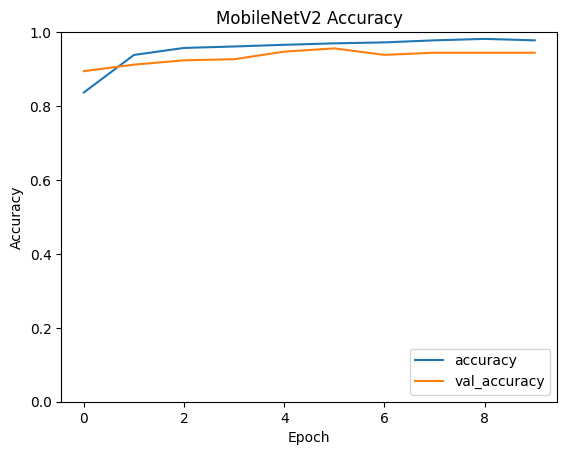

11/11 [==============================] - 4s 282ms/step


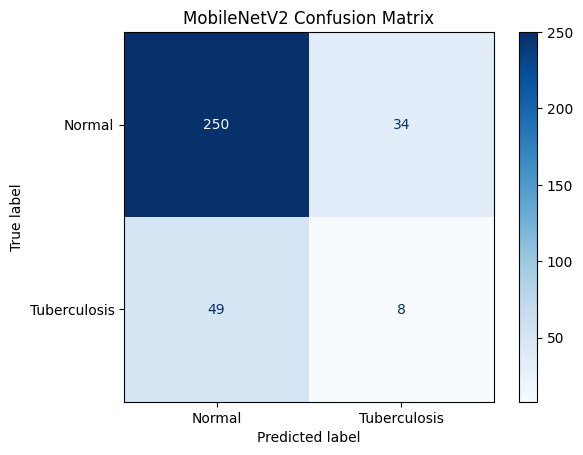

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved MobileNetV2 model to saved_models/MobileNetV2_saved.h5


In [ ]:
# List of base models with their respective input shapes
base_models1 = [
    (MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'MobileNetV2'),
]
model_training(base_models1)

Training InceptionV3...
Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 0.4534 - accuracy: 0.8304

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 74s 705ms/step - loss: 0.4534 - accuracy: 0.8304 - val_loss: 0.2377 - val_accuracy: 0.9179 - lr: 1.0000e-04
Epoch 2/10
96/96 [==============================] - 64s 669ms/step - loss: 0.2667 - accuracy: 0.9059 - val_loss: 0.1666 - val_accuracy: 0.9472 - lr: 1.0000e-04
Epoch 3/10
96/96 [==============================] - 65s 672ms/step - loss: 0.2144 - accuracy: 0.9170 - val_loss: 0.1371 - val_accuracy: 0.9531 - lr: 1.0000e-04
Epoch 4/10
96/96 [==============================] - 66s 692ms/step - loss: 0.1838 - accuracy: 0.9294 - val_loss: 0.1332 - val_accuracy: 0.9531 - lr: 1.0000e-04
Epoch 5/10
96/96 [==============================] - 63s 657ms/step - loss: 0.1676 - accuracy: 0.9399 - val_loss: 0.1394 - val_accuracy: 0.9560 - lr: 1.0000e-04
Epoch 6/10
96/96 [==============================] - 66s 679ms/step - loss: 0.1578 - accuracy: 0.9405 - val_loss: 0.1260 - val_accuracy: 0.9648 - lr: 1.0000e-04
Epoch 7/10
96/96 [==============================] -

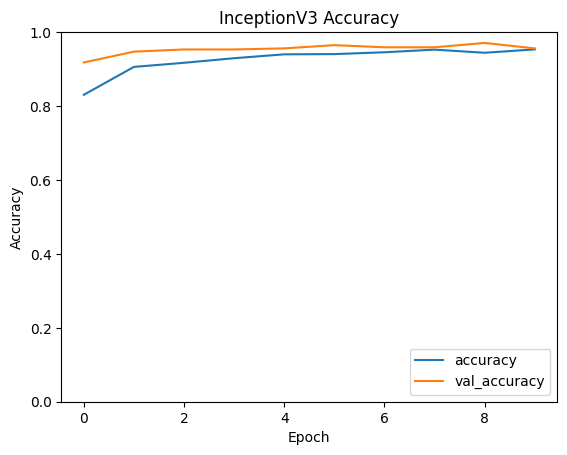

11/11 [==============================] - 4s 267ms/step


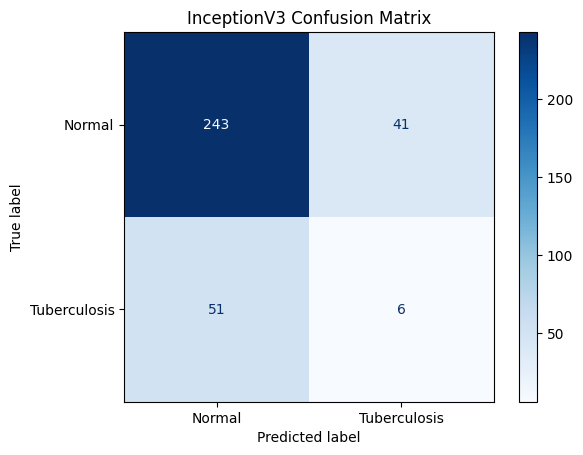

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved InceptionV3 model to saved_models/InceptionV3_saved.h5


In [ ]:
base_models2 = [
  (InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3)), (299, 299, 3), 'InceptionV3')
]
model_training (base_models2)

83683744/83683744 [==============================] - 1s 0us/step
Training Xception...
Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 0.3339 - accuracy: 0.8651

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 74s 699ms/step - loss: 0.3339 - accuracy: 0.8651 - val_loss: 0.1984 - val_accuracy: 0.9238 - lr: 1.0000e-04
Epoch 2/10
96/96 [==============================] - 67s 702ms/step - loss: 0.2244 - accuracy: 0.9167 - val_loss: 0.1816 - val_accuracy: 0.9296 - lr: 1.0000e-04
Epoch 3/10
96/96 [==============================] - 65s 677ms/step - loss: 0.1713 - accuracy: 0.9376 - val_loss: 0.1378 - val_accuracy: 0.9443 - lr: 1.0000e-04
Epoch 4/10
96/96 [==============================] - 67s 698ms/step - loss: 0.1582 - accuracy: 0.9379 - val_loss: 0.1275 - val_accuracy: 0.9472 - lr: 1.0000e-04
Epoch 5/10
96/96 [==============================] - 65s 682ms/step - loss: 0.1414 - accuracy: 0.9510 - val_loss: 0.1012 - val_accuracy: 0.9560 - lr: 1.0000e-04
Epoch 6/10
96/96 [==============================] - 68s 706ms/step - loss: 0.1309 - accuracy: 0.9526 - val_loss: 0.1051 - val_accuracy: 0.9560 - lr: 1.0000e-04
Epoch 7/10
96/96 [==============================] -

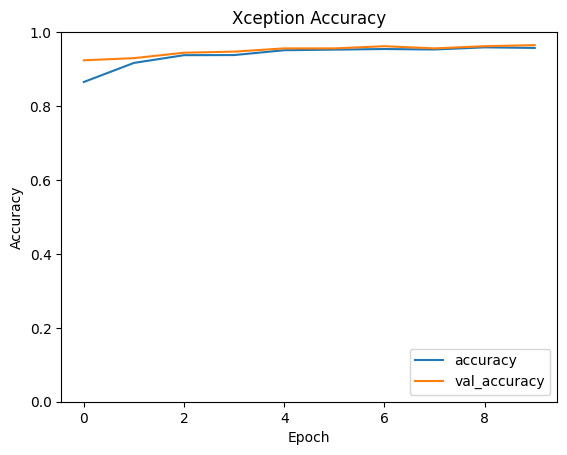

11/11 [==============================] - 4s 284ms/step


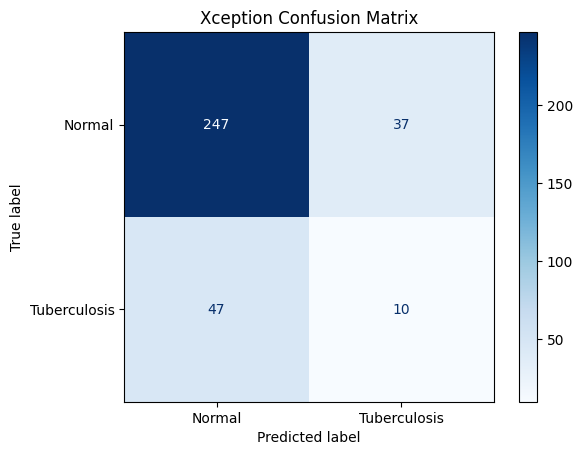

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved Xception model to saved_models/Xception_saved.h5


In [ ]:
base_models3 = [
  (Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3)), (299, 299, 3), 'Xception')
]
model_training (base_models3)

94668760/94668760 [==============================] - 1s 0us/step
Training ResNet50V2...
Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.8582

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 88s 791ms/step - loss: 0.3708 - accuracy: 0.8582 - val_loss: 0.1772 - val_accuracy: 0.9326 - lr: 1.0000e-04
Epoch 2/10
96/96 [==============================] - 75s 781ms/step - loss: 0.1891 - accuracy: 0.9301 - val_loss: 0.1490 - val_accuracy: 0.9443 - lr: 1.0000e-04
Epoch 3/10
96/96 [==============================] - 74s 774ms/step - loss: 0.1489 - accuracy: 0.9435 - val_loss: 0.1267 - val_accuracy: 0.9531 - lr: 1.0000e-04
Epoch 4/10
96/96 [==============================] - 72s 749ms/step - loss: 0.1315 - accuracy: 0.9487 - val_loss: 0.1088 - val_accuracy: 0.9560 - lr: 1.0000e-04
Epoch 5/10
96/96 [==============================] - 74s 766ms/step - loss: 0.1288 - accuracy: 0.9494 - val_loss: 0.1174 - val_accuracy: 0.9560 - lr: 1.0000e-04
Epoch 6/10
96/96 [==============================] - 73s 761ms/step - loss: 0.1210 - accuracy: 0.9582 - val_loss: 0.0869 - val_accuracy: 0.9677 - lr: 1.0000e-04
Epoch 7/10
96/96 [==============================] -

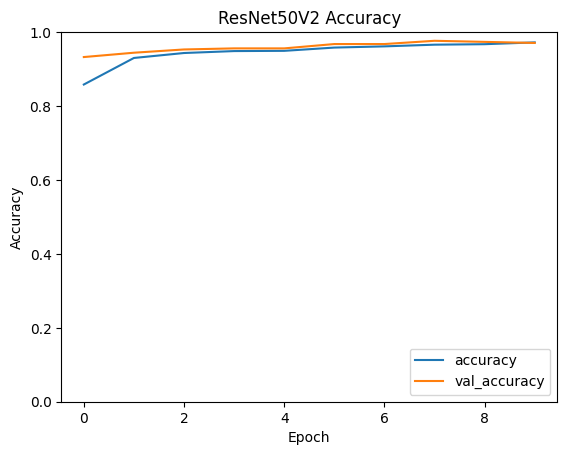

11/11 [==============================] - 4s 327ms/step


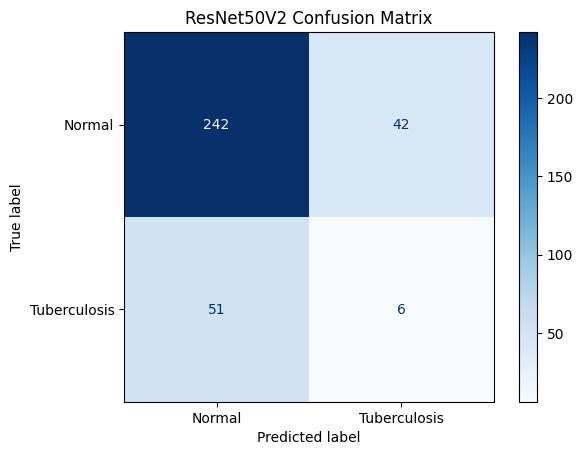

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved ResNet50V2 model to saved_models/ResNet50V2_saved.h5


In [10]:
base_models4 = [
  (ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'ResNet50V2')
]
model_training (base_models4)

29084464/29084464 [==============================] - 0s 0us/step
Training DenseNet121...
Epoch 1/10
96/96 [==============================] - 104s 957ms/step - loss: 0.4214 - accuracy: 0.8383 - val_loss: 0.2504 - val_accuracy: 0.8915 - lr: 1.0000e-04
Epoch 2/10
96/96 [==============================] - 73s 760ms/step - loss: 0.2604 - accuracy: 0.8991 - val_loss: 0.1877 - val_accuracy: 0.9238 - lr: 1.0000e-04
Epoch 3/10
96/96 [==============================] - 72s 754ms/step - loss: 0.2091 - accuracy: 0.9183 - val_loss: 0.1219 - val_accuracy: 0.9560 - lr: 1.0000e-04
Epoch 4/10
96/96 [==============================] - 73s 753ms/step - loss: 0.1636 - accuracy: 0.9363 - val_loss: 0.1505 - val_accuracy: 0.9384 - lr: 1.0000e-04
Epoch 5/10
96/96 [==============================] - 70s 729ms/step - loss: 0.1488 - accuracy: 0.9441 - val_loss: 0.1534 - val_accuracy: 0.9384 - lr: 1.0000e-04
Epoch 6/10
96/96 [==============================] - 72s 752ms/step - loss: 0.1349 - accuracy: 0.9500 - val_los

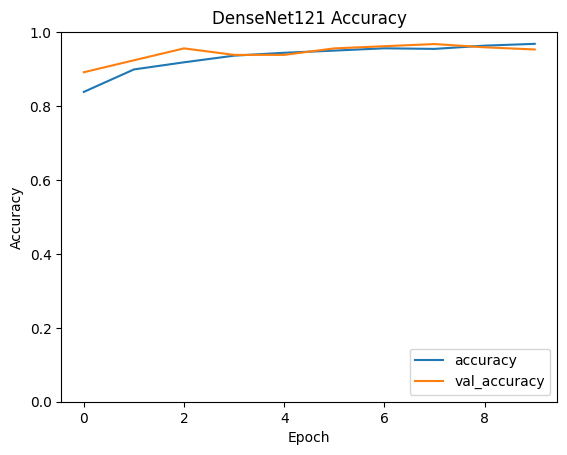

11/11 [==============================] - 6s 343ms/step


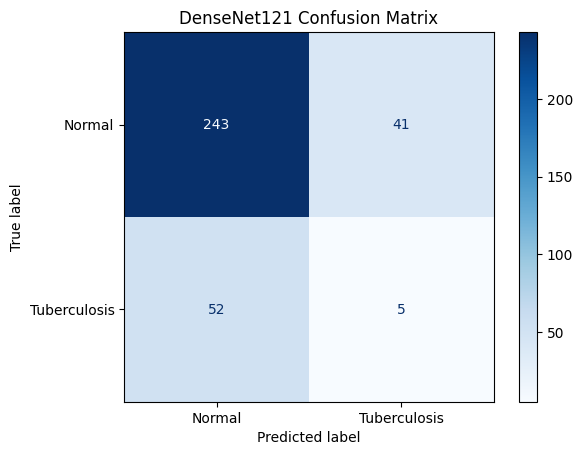

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved DenseNet121 model to saved_models/DenseNet121_saved.h5


In [11]:
# List of base models with their respective input shapes
base_models5 = [
   (DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'DenseNet121')
]
model_training (base_models5)

# Testing and labeling unseen data

In [12]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing import image

# Load test dataset
test_df = pd.read_csv('/content/tuberculosis-tb-chest-xray-dataset1/test_data.csv')

# Load class indices (assuming you have train_generator with class indices saved)
class_indices_inverse = {v: k for k, v in train_generator.class_indices.items()}

# Directory containing the saved models
model_dir = '/content/saved_models'

# Define batch size
batch_size = 32

# Function to process images in batches
def process_images_in_batches(image_paths, model, target_size, batch_size):
    num_images = len(image_paths)
    num_batches = (num_images + batch_size - 1) // batch_size  # Calculate number of batches

    all_predictions = []

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_images)
        batch_paths = image_paths[start_idx:end_idx]

        batch_images = []
        for img_path in batch_paths:
            img = image.load_img(img_path, target_size=target_size)
            img = image.img_to_array(img)
            img = img / 255.0
            batch_images.append(img)

        batch_images = np.array(batch_images)
        batch_predictions_probs = model.predict(batch_images)
        batch_predictions = np.argmax(batch_predictions_probs, axis=1)

        all_predictions.extend(batch_predictions)

    return all_predictions

# Iterate over each model file in the directory
for model_file in os.listdir(model_dir):
    if model_file.endswith('.h5'):
        # Load the model
        model_path = os.path.join(model_dir, model_file)
        model = load_model(model_path)

        # Determine target size based on model
        if "Xception_saved" in model_file or "InceptionV3_saved" in model_file:
            target_size = (299, 299)
        else:
            target_size = (224, 224)

        # Process images in batches and make predictions
        image_paths = test_df['Image_Path'].tolist()
        prediction = process_images_in_batches(image_paths, model, target_size, batch_size)

        # Map predictions to class labels
        prediction_labels = [class_indices_inverse[label] for label in prediction]

        # Create a DataFrame with predictions
        predicted_df = pd.DataFrame({
            'Image_Path': test_df['Image_Path'],
            'Label': prediction_labels,
        })

        # Save predictions to CSV
        csv_path = f'/content/saved_models/predicted_{model_file.split(".")[0]}.csv'
        predicted_df.to_csv(csv_path, header=True, index=False)

        print(f"Predictions saved to {csv_path}")

1/1 [==============================] - 4s 4s/step
Predictions saved to /content/saved_models/predicted_ResNet50V2_saved.csv
1/1 [==============================] - 6s 6s/step
Predictions saved to /content/saved_models/predicted_DenseNet121_saved.csv


# image label and prediction and visualization

Predictions using: predicted_Xception_saved


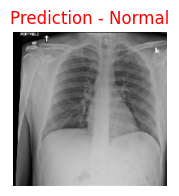

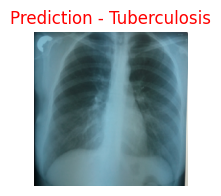

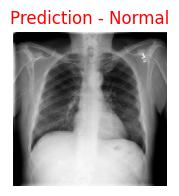

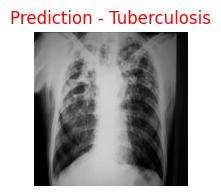

Predictions using: predicted_InceptionV3_saved


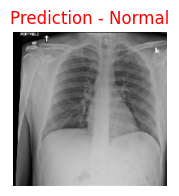

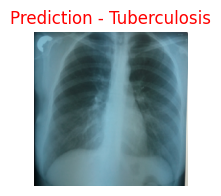

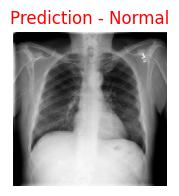

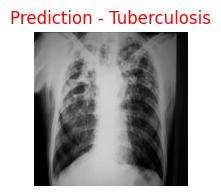

Predictions using: predicted_MobileNetV2_saved


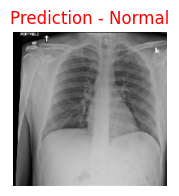

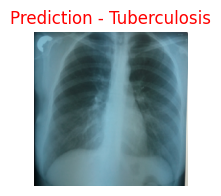

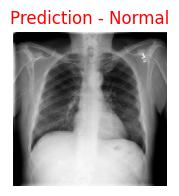

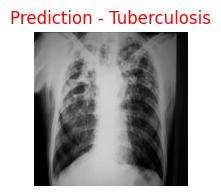

Predictions using: predicted_DenseNet121_saved


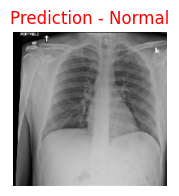

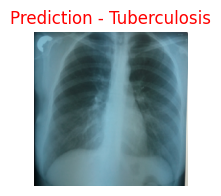

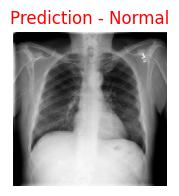

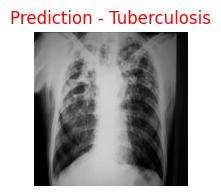

Predictions using: predicted_ResNet50V2_saved


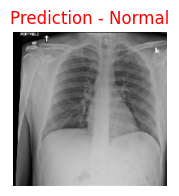

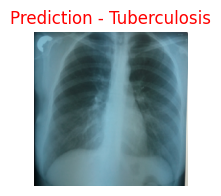

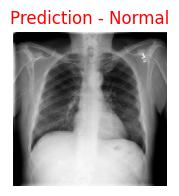

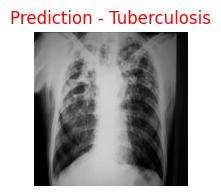

In [14]:
import csv
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Example usage
filenames = [
    '/content/tuberculosis-tb-chest-xray-dataset1/TB_Chest_Radiography_Database/Normal/Normal-1157.png',
    '/content/tuberculosis-tb-chest-xray-dataset1/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-499.png',
    '/content/tuberculosis-tb-chest-xray-dataset1/TB_Chest_Radiography_Database/Normal/Normal-1922.png',
    '/content/tuberculosis-tb-chest-xray-dataset1/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-539.png'
]

def load_predicted_labels(csv_file_path):
    predicted_labels = {}
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            predicted_labels[row['Image_Path']] = row['Label']
    return predicted_labels

def visualize_predictions(filenames, predicted_labels):
    for filename in filenames:
        img = image.load_img(filename, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_processed = img_array / 255.0  # Normalize the image

        # Check if the filename is in predicted_labels
        if filename in predicted_labels:
            predicted_class_name = predicted_labels[filename]
        else:
            print(f"Filename not found: {filename}")
            predicted_class_name = "Unknown"  # Handle cases where filename not found

        plt.figure(figsize=(2, 2))
        plt.imshow(img_processed)  # Display the processed image
        plt.title(f"Prediction - {predicted_class_name}", size=12, color='red')
        plt.axis('off')  # Hide axes
        plt.show()

# Directory containing the predicted CSV files
csv_dir = '/content/saved_models'

# Iterate over each CSV file in the directory
for csv_file in os.listdir(csv_dir):
    if csv_file.startswith('predicted_') and csv_file.endswith('.csv'):
        # Determine the model name
        model_name = csv_file.split('.')[0]

        # Path to the CSV file containing predictions for the current model
        predicted_csv_file = os.path.join(csv_dir, csv_file)

        # Load predicted labels from the CSV file
        predicted_labels = load_predicted_labels(predicted_csv_file)

        # Predict and plot images using predicted labels
        print(f"Predictions using: {model_name}")
        visualize_predictions(filenames, predicted_labels)
